# Machine Learning Pipeline - Model Training

In this notebook, we pick up the transformed datasets and the selected variables that we saved in the previous notebooks.

# Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we **set the seed**.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline as ImbPipeline

# Dividir datos en entrenamiento y prueba
select_features_by_model = {
    "lgbm" : ['24M_MONTO', 'EDAD', 'PRINCIPALIDAD_CONSUMO',
              'ULTIMA_AGRUPACION', 'intentos_totales',
              'max_intentos_en_un_mes', 'veces_respuesta_positiva'],
    "KBest": ['COMPETITIVIDAD', 'GENERO', 'veces_respuesta_negativa',
              'Bancos_TC_Total', 'Retail_TC_Total', 'PLD_Entidades',
              'Tiene_Deuda_PLD', 'dias_ultima_gestion_na',
              'veces_solicitud_seguimiento_na', 'NUEVA_OFERTA']
}
col_all = list(set(select_features_by_model["lgbm"] + select_features_by_model["KBest"]  ))
select_features_by_model["all"] = col_all
select_features_by_model.keys()

dict_keys(['lgbm', 'KBest', 'all'])

In [2]:
import mlflow
import os
mlflow.set_experiment("banbuf-pld-exp") # Trackeamos los parametros, el modelo y los resultados


<Experiment: artifact_location='file:///C:/Users/Luis%20Villacorta/Documents/Obsidian/TSP%20Machine%20Learning/_python/TSP_Machine_Learning/notebooks/mlruns/646513392992145906', creation_time=1741987454301, experiment_id='646513392992145906', last_update_time=1741987454301, lifecycle_stage='active', name='banbuf-pld-exp', tags={}>

In [3]:
# cargar el conjunto de entrenamiento y prueba con las engineered variables

# Nosotros construimos y guardamos estos conjuntos de datos en la lección anterior.
# Si no lo has hecho, revisa el NOTEBOOK anterior para saber cómo crear estos conjuntos de datos.
X_train = pd.read_parquet('../data/xtrain_postprocess.parquet')
X_test= pd.read_parquet('../data/xtest_postprocess.parquet')
# Cargar el objetivo (recuerda que el objetivo está transformado logarítmicamente).
y_train = pd.read_parquet('../data/ytrain_postprocess.parquet')
y_test = pd.read_parquet('../data/ytest_postprocess.parquet')

y_train.head()
X_train.head()

,24M_MONTO,24M_TASA,EDAD,MARCA_LABORAL,PROPENSION,COMPETITIVIDAD,PRINCIPALIDAD_CONSUMO,ULTIMA_AGRUPACION,RANGO_RCI,ESTADO_CIVIL,...,dias_ultima_gestion_na,veces_sin_respuesta_na,veces_solicitud_seguimiento_na,promedio_dias_entre_gestiones_na,max_intentos_en_un_mes_na,veces_respuesta_positiva_na,veces_respuesta_negativa_na,ESTADO_TASA,ESTADO_OFERTA,NUEVA_OFERTA
0,0.316261,0.949895,0.072226,0.666667,0.0,1.0,0.333333,1.0,0.50,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0
1,0.803713,0.839976,0.358849,0.000000,1.0,1.0,0.333333,0.0,0.25,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.666667,0.0
2,0.726257,0.777914,0.491479,0.000000,1.0,1.0,0.666667,0.0,0.50,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.333333,0.0
3,0.616009,0.919278,0.656332,0.666667,1.0,0.0,0.000000,0.0,0.25,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.333333,0.0
4,0.651222,1.000000,0.688743,0.666667,1.0,0.0,0.000000,1.0,0.00,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0


In [4]:
# 1. Oversampling con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 2. Undersampling con NearMiss
nearmiss = NearMiss()
X_train_nm, y_train_nm = nearmiss.fit_resample(X_train, y_train)



In [5]:
# Modelos a probar
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
    "Ridge Classifier": RidgeClassifier(class_weight='balanced'),
    "SVM - Linear Kernel": SVC(kernel='linear', probability=True, class_weight='balanced')
}

# Evaluar cada modelo en cada conjunto de datos balanceado
datasets = {
    "Original": (X_train, y_train),
    "SMOTE": (X_train_smote, y_train_smote),
    "NearMiss": (X_train_nm, y_train_nm)
}


In [6]:
param_grids = {
    "Logistic Regression": {
        "C": np.logspace(-4, 4, 20),  # Regularización
        "penalty": ["l1", "l2", "elasticnet", "none"],
        "solver": ["liblinear", "saga", "newton-cg", "lbfgs"],
        "max_iter": [100, 300, 500, 1000]
    },
    
    "Ridge Classifier": {
        "alpha": np.logspace(-4, 4, 20),  # Regularización
        "solver": ["auto", "saga", "lsqr"],
        "fit_intercept": [True, False]
    },
    
    "SVM - Linear Kernel": {
        "C": np.logspace(-4, 4, 20),  # Regularización
        "kernel": ["linear", "rbf", "poly"],  # Tipo de kernel
        "gamma": ["scale", "auto", 0.1, 1, 10],  # Solo para `rbf` y `poly`
        "degree": [2, 3, 4, 5],  # Solo para `poly`
        "probability": [True]  # Para usar predict_proba()
    }
}


In [7]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# 📌 Iteramos sobre cada modelo
for model_name, model in models.items():
    param_grid = param_grids.get(model_name, {})  # Obtiene los hiperparámetros si existen
    
    for features_name, features in select_features_by_model.items():
        for data_name, (X_bal, y_bal) in datasets.items():
            
            # 📌 Realizamos búsqueda de hiperparámetros
            search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=3, scoring="f1", random_state=42)
            search.fit(X_bal[features], y_bal)
            best_model = search.best_estimator_
            best_params = search.best_params_

            # 📌 Iniciamos un experimento en MLflow
            with mlflow.start_run(run_name=f"{model_name} - {features_name} - {data_name}"):
                print(f"\n🔹 Entrenando {model_name} con {features_name} en {data_name}...")
                
                # Entrenamos el mejor modelo encontrado
                best_model.fit(X_bal[features], y_bal)
                y_pred = best_model.predict(X_test[features])

                # 📌 Calculamos métricas
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)

                # 📌 Registramos en MLflow
                mlflow.log_param("Modelo", model_name)
                mlflow.log_param("Dataset", data_name)
                mlflow.log_param("Feature Set", features_name)
                mlflow.log_params(best_params)  # Registramos los hiperparámetros óptimos

                mlflow.log_metric("Accuracy", accuracy)
                mlflow.log_metric("Precision", precision)
                mlflow.log_metric("Recall", recall)
                mlflow.log_metric("F1-score", f1)

                # 📌 Guardamos el modelo entrenado
                mlflow.sklearn.log_model(best_model, f"{model_name}_{features_name}_{data_name}")

                print(f"📌 Evaluación en {data_name}:\n", classification_report(y_test, y_pred))

                mlflow.end_run()

D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected.


🔹 Entrenando Logistic Regression con lgbm en Original...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:27:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


📌 Evaluación en Original:
               precision    recall  f1-score   support

         0.0       1.00      0.67      0.80     21090
         1.0       0.01      0.65      0.01        60

    accuracy                           0.67     21150
   macro avg       0.50      0.66      0.41     21150
weighted avg       1.00      0.67      0.80     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected.


🔹 Entrenando Logistic Regression con lgbm en SMOTE...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:27:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = 

📌 Evaluación en SMOTE:
               precision    recall  f1-score   support

         0.0       1.00      0.68      0.81     21090
         1.0       0.01      0.63      0.01        60

    accuracy                           0.68     21150
   macro avg       0.50      0.66      0.41     21150
weighted avg       1.00      0.68      0.81     21150


🔹 Entrenando Logistic Regression con lgbm en NearMiss...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:27:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = 

📌 Evaluación en NearMiss:
               precision    recall  f1-score   support

         0.0       1.00      0.11      0.20     21090
         1.0       0.00      0.83      0.01        60

    accuracy                           0.11     21150
   macro avg       0.50      0.47      0.10     21150
weighted avg       0.99      0.11      0.20     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected.


🔹 Entrenando Logistic Regression con KBest en Original...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:27:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


📌 Evaluación en Original:
               precision    recall  f1-score   support

         0.0       1.00      0.66      0.80     21090
         1.0       0.01      0.72      0.01        60

    accuracy                           0.66     21150
   macro avg       0.50      0.69      0.40     21150
weighted avg       1.00      0.66      0.79     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected.


🔹 Entrenando Logistic Regression con KBest en SMOTE...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:27:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = 

📌 Evaluación en SMOTE:
               precision    recall  f1-score   support

         0.0       1.00      0.67      0.80     21090
         1.0       0.01      0.72      0.01        60

    accuracy                           0.67     21150
   macro avg       0.50      0.69      0.41     21150
weighted avg       1.00      0.67      0.80     21150


🔹 Entrenando Logistic Regression con KBest en NearMiss...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:28:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


📌 Evaluación en NearMiss:
               precision    recall  f1-score   support

         0.0       0.99      0.06      0.12     21090
         1.0       0.00      0.87      0.01        60

    accuracy                           0.07     21150
   macro avg       0.50      0.47      0.06     21150
weighted avg       0.99      0.07      0.12     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected.


🔹 Entrenando Logistic Regression con all en Original...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:28:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


📌 Evaluación en Original:
               precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     21090
         1.0       0.01      0.72      0.01        60

    accuracy                           0.71     21150
   macro avg       0.50      0.71      0.42     21150
weighted avg       1.00      0.71      0.83     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected.


🔹 Entrenando Logistic Regression con all en SMOTE...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:28:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = 

📌 Evaluación en SMOTE:
               precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     21090
         1.0       0.01      0.67      0.01        60

    accuracy                           0.71     21150
   macro avg       0.50      0.69      0.42     21150
weighted avg       1.00      0.71      0.83     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected.


🔹 Entrenando Logistic Regression con all en NearMiss...


2025/03/14 16:28:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

📌 Evaluación en NearMiss:
               precision    recall  f1-score   support

         0.0       0.99      0.04      0.07     21090
         1.0       0.00      0.92      0.01        60

    accuracy                           0.04     21150
   macro avg       0.50      0.48      0.04     21150
weighted avg       0.99      0.04      0.07     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array w


🔹 Entrenando Ridge Classifier con lgbm en Original...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:28:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


📌 Evaluación en Original:
               precision    recall  f1-score   support

         0.0       1.00      0.67      0.80     21090
         1.0       0.01      0.63      0.01        60

    accuracy                           0.67     21150
   macro avg       0.50      0.65      0.41     21150
weighted avg       1.00      0.67      0.80     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array w


🔹 Entrenando Ridge Classifier con lgbm en SMOTE...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:29:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

📌 Evaluación en SMOTE:
               precision    recall  f1-score   support

         0.0       1.00      0.66      0.79     21090
         1.0       0.01      0.65      0.01        60

    accuracy                           0.66     21150
   macro avg       0.50      0.66      0.40     21150
weighted avg       1.00      0.66      0.79     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array w


🔹 Entrenando Ridge Classifier con lgbm en NearMiss...


2025/03/14 16:29:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

📌 Evaluación en NearMiss:
               precision    recall  f1-score   support

         0.0       1.00      0.17      0.29     21090
         1.0       0.00      0.80      0.01        60

    accuracy                           0.17     21150
   macro avg       0.50      0.48      0.15     21150
weighted avg       0.99      0.17      0.28     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array w


🔹 Entrenando Ridge Classifier con KBest en Original...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:29:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


📌 Evaluación en Original:
               precision    recall  f1-score   support

         0.0       1.00      0.66      0.80     21090
         1.0       0.01      0.72      0.01        60

    accuracy                           0.66     21150
   macro avg       0.50      0.69      0.40     21150
weighted avg       1.00      0.66      0.79     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array w


🔹 Entrenando Ridge Classifier con KBest en SMOTE...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:29:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

📌 Evaluación en SMOTE:
               precision    recall  f1-score   support

         0.0       1.00      0.64      0.78     21090
         1.0       0.01      0.70      0.01        60

    accuracy                           0.64     21150
   macro avg       0.50      0.67      0.40     21150
weighted avg       1.00      0.64      0.78     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array w


🔹 Entrenando Ridge Classifier con KBest en NearMiss...


2025/03/14 16:29:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


📌 Evaluación en NearMiss:
               precision    recall  f1-score   support

         0.0       1.00      0.08      0.15     21090
         1.0       0.00      0.87      0.01        60

    accuracy                           0.08     21150
   macro avg       0.50      0.47      0.08     21150
weighted avg       0.99      0.08      0.14     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array w


🔹 Entrenando Ridge Classifier con all en Original...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:30:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


📌 Evaluación en Original:
               precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     21090
         1.0       0.01      0.75      0.01        60

    accuracy                           0.71     21150
   macro avg       0.50      0.73      0.42     21150
weighted avg       1.00      0.71      0.83     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array w


🔹 Entrenando Ridge Classifier con all en SMOTE...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:30:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

📌 Evaluación en SMOTE:
               precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     21090
         1.0       0.01      0.70      0.01        60

    accuracy                           0.71     21150
   macro avg       0.50      0.71      0.42     21150
weighted avg       1.00      0.71      0.83     21150



D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y 


🔹 Entrenando Ridge Classifier con all en NearMiss...


D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2025/03/14 16:30:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


📌 Evaluación en NearMiss:
               precision    recall  f1-score   support

         0.0       1.00      0.10      0.18     21090
         1.0       0.00      0.85      0.01        60

    accuracy                           0.10     21150
   macro avg       0.50      0.47      0.09     21150
weighted avg       0.99      0.10      0.18     21150



# ML Flow
Cargamos el mejor modelo que hayamos obtenido

In [8]:
import mlflow

mlflow.search_experiments()


[<Experiment: artifact_location='file:///C:/Users/Luis%20Villacorta/Documents/Obsidian/TSP%20Machine%20Learning/_python/TSP_Machine_Learning/notebooks/mlruns/646513392992145906', creation_time=1741987454301, experiment_id='646513392992145906', last_update_time=1741987454301, lifecycle_stage='active', name='banbuf-pld-exp', tags={}>,
 <Experiment: artifact_location='file:///C:/Users/Luis%20Villacorta/Documents/Obsidian/TSP%20Machine%20Learning/_python/TSP_Machine_Learning/notebooks/mlruns/0', creation_time=1741987454284, experiment_id='0', last_update_time=1741987454284, lifecycle_stage='active', name='Default', tags={}>]

In [29]:
import mlflow

# ID del experimento donde están tus modelos
experiment_id = "646513392992145906"

# Buscar los runs ordenados por mejor F1-score
runs = mlflow.search_runs(experiment_id, order_by=["metrics.f1_score DESC"])

# Mostrar los mejores modelos
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Recall,metrics.Precision,metrics.Accuracy,metrics.F1-score,...,params.Dataset,params.Feature Set,params.penalty,params.max_iter,params.C,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.log-model.history
0,0036c5cd456c4c9ea80f5c998c392ae9,646513392992145906,FINISHED,file:///C:/Users/Luis%20Villacorta/Documents/O...,2025-03-14 21:30:40.131000+00:00,2025-03-14 21:30:42.725000+00:00,0.850000,0.002673,0.099764,0.005329,...,NearMiss,all,None,None,None,LOCAL,Luis Villacorta,D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-p...,Ridge Classifier - all - NearMiss,"[{""run_id"": ""0036c5cd456c4c9ea80f5c998c392ae9""..."
1,d9a757015fc14141b9717f021c3018be,646513392992145906,FINISHED,file:///C:/Users/Luis%20Villacorta/Documents/O...,2025-03-14 21:30:34.552000+00:00,2025-03-14 21:30:39.313000+00:00,0.700000,0.006844,0.710969,0.013555,...,SMOTE,all,None,None,None,LOCAL,Luis Villacorta,D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-p...,Ridge Classifier - all - SMOTE,"[{""run_id"": ""d9a757015fc14141b9717f021c3018be""..."
2,e59599cd5d3e4cfda87088b307978035,646513392992145906,FINISHED,file:///C:/Users/Luis%20Villacorta/Documents/O...,2025-03-14 21:30:04.598000+00:00,2025-03-14 21:30:07.319000+00:00,0.750000,0.007298,0.709882,0.014456,...,Original,all,None,None,None,LOCAL,Luis Villacorta,D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-p...,Ridge Classifier - all - Original,"[{""run_id"": ""e59599cd5d3e4cfda87088b307978035""..."
3,c5d01687d79c4ea4a3202061b2909288,646513392992145906,FINISHED,file:///C:/Users/Luis%20Villacorta/Documents/O...,2025-03-14 21:29:54.299000+00:00,2025-03-14 21:29:56.920000+00:00,0.866667,0.002668,0.080662,0.005320,...,NearMiss,KBest,None,None,None,LOCAL,Luis Villacorta,D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-p...,Ridge Classifier - KBest - NearMiss,"[{""run_id"": ""c5d01687d79c4ea4a3202061b2909288""..."
4,302aca9a96584e84b90277eed7892907,646513392992145906,FINISHED,file:///C:/Users/Luis%20Villacorta/Documents/O...,2025-03-14 21:29:51.244000+00:00,2025-03-14 21:29:54.064000+00:00,0.700000,0.005560,0.643972,0.011032,...,SMOTE,KBest,None,None,None,LOCAL,Luis Villacorta,D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-p...,Ridge Classifier - KBest - SMOTE,"[{""run_id"": ""302aca9a96584e84b90277eed7892907""..."
5,1727064b65494b16b46a66ac11eb9302,646513392992145906,FINISHED,file:///C:/Users/Luis%20Villacorta/Documents/O...,2025-03-14 21:29:20.364000+00:00,2025-03-14 21:29:23.065000+00:00,0.716667,0.006016,0.663262,0.011931,...,Original,KBest,None,None,None,LOCAL,Luis Villacorta,D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-p...,Ridge Classifier - KBest - Original,"[{""run_id"": ""1727064b65494b16b46a66ac11eb9302""..."
6,a3ba6c9ca02c47c8993c1ab7e9818bfa,646513392992145906,FINISHED,file:///C:/Users/Luis%20Villacorta/Documents/O...,2025-03-14 21:29:10.614000+00:00,2025-03-14 21:29:13.263000+00:00,0.800000,0.002722,0.168085,0.005426,...,NearMiss,lgbm,None,None,None,LOCAL,Luis Villacorta,D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-p...,Ridge Classifier - lgbm - NearMiss,"[{""run_id"": ""a3ba6c9ca02c47c8993c1ab7e9818bfa""..."
7,49e2ae9c59d3458cab56b8d0209371de,646513392992145906,FINISHED,file:///C:/Users/Luis%20Villacorta/Documents/O...,2025-03-14 21:29:06.275000+00:00,2025-03-14 21:29:10.307000+00:00,0.650000,0.005412,0.660142,0.010735,...,SMOTE,lgbm,None,None,None,LOCAL,Luis Villacorta,D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-p...,Ridge Classifier - lgbm - SMOTE,"[{""run_id"": ""49e2ae9c59d3458cab56b8d0209371de""..."
8,69848d3f6288441cb7e2aca50fdd0713,646513392992145906,FINISHED,file:///C:/Users/Luis%20Villacorta/Documents/O...,2025-03-14 21:28:44.397000+00:00,2025-03-14 21:28:46.994000+00:00,0.633333,0.005430,0.669882,0.010768,...,Original,lgbm,None,None,None,LOCAL,Luis Villacorta,D:\anaconda3\envs\mlops_d11_p310_M1\lib\site-p...,Ridge Classifier - lgbm - Original,"[{""run_id"": ""69848d3f6288441cb7e2aca50fdd0713""..

In [31]:


import mlflow

# ID del mejor run (cámbialo según tu experimento)
best_run_id = "e59599cd5d3e4cfda87088b307978035"

# Cliente de MLflow
client = mlflow.tracking.MlflowClient()

# Obtener lista de artefactos dentro del run
artifacts = client.list_artifacts(best_run_id)

# Filtrar nombres de carpetas dentro de "artifacts/"
artifact_paths = [artifact.path for artifact in artifacts]

# Mostrar nombres de carpetas dentro de artifacts/
print("🔍 Carpetas encontradas en artifacts:", artifact_paths)


🔍 Carpetas encontradas en artifacts: ['Ridge Classifier_all_Original']


In [70]:
import mlflow.pyfunc

# Asegurar que al menos haya un artefacto en la carpeta
if artifact_paths:
    model_folder = artifact_paths[0]  # Tomar el primer modelo encontrado

    # Ruta dinámica del modelo
    model_uri = f"runs:/{best_run_id}/{model_folder}"
    
    # Cargar modelo
    loaded_model = mlflow.pyfunc.load_model(model_uri)
    
    print(f"✅ Modelo '{model_folder}' cargado con éxito.")
else:
    print("⚠️ No se encontró ningún modelo en artifacts/")


✅ Modelo 'Ridge Classifier_all_Original' cargado con éxito.


In [72]:
raw_model = loaded_model.get_raw_model()

expected_features = raw_model.feature_names_in_
print("📌 Columnas esperadas:", expected_features)


📌 Columnas esperadas: ['EDAD' 'PLD_Entidades' 'NUEVA_OFERTA' 'max_intentos_en_un_mes'
 'Tiene_Deuda_PLD' 'veces_respuesta_positiva' 'Bancos_TC_Total'
 'intentos_totales' 'veces_respuesta_negativa'
 'veces_solicitud_seguimiento_na' 'Retail_TC_Total'
 'PRINCIPALIDAD_CONSUMO' 'dias_ultima_gestion_na' 'COMPETITIVIDAD'
 'ULTIMA_AGRUPACION' '24M_MONTO' 'GENERO']


### Feature importance

In [76]:
import pandas as pd
import numpy as np

# Obtener la importancia de características (coeficientes)
feature_importance = np.abs(loaded_model.get_raw_model().coef_).flatten()

# Crear un DataFrame ordenado por importancia
feature_importance_df = pd.DataFrame({
    'Feature': expected_features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
5,veces_respuesta_positiva,8.766050
3,max_intentos_en_un_mes,0.806500
1,PLD_Entidades,0.659501
0,EDAD,0.637998
2,NUEVA_OFERTA,0.425605
15,24M_MONTO,0.391920
8,veces_respuesta_negativa,0.243113
13,COMPETITIVIDAD,0.197829
14,ULTIMA_AGRUPACION,0.190907
6,Bancos_TC_Total,0.164820


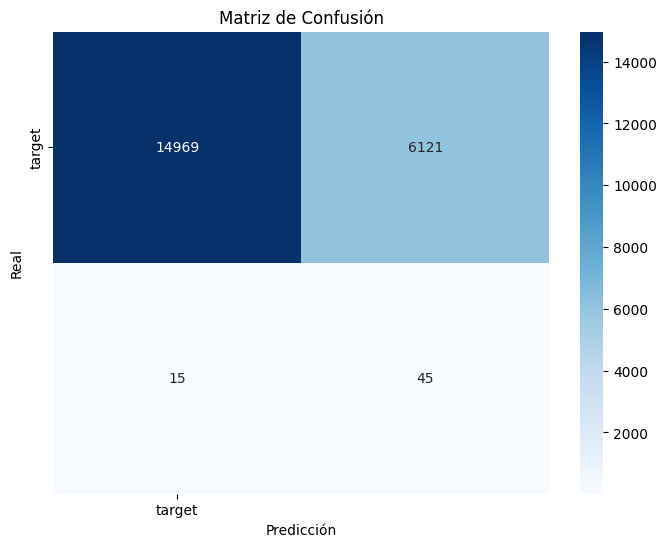

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtener predicciones
y_pred = loaded_model.predict(X_test[expected_features])

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
labels = sorted(set(y_test))  # Asegurar que los labels están en orden

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()



In [74]:
xd = y_test["target"].astype(int).to_list()
# Generar el reporte de clasificación
report = classification_report(xd, y_pred)

print("📌 Reporte de Clasificación:\n", report)


📌 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83     21090
           1       0.01      0.75      0.01        60

    accuracy                           0.71     21150
   macro avg       0.50      0.73      0.42     21150
weighted avg       1.00      0.71      0.83     21150



## Save the Model

In [69]:
# estamos contentos con nuestro modelo, así que lo guardamos
# para poder evaluar nuevos datos
import joblib
joblib.dump(loaded_model, '../src/model_clasification.joblib')

['../src/model_clasification.joblib']